# Midterm Assignment, topic 1: Asymmetric Cournot competition

> The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

> The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Asymmetric Cournot competition model with product differentiation

Consider a market where two firms compete in quantities of the two
differentiated products. The inverse demand for the two firms is given
by the 2-valued function $ P(q) $

$$
P(q) =
\begin{bmatrix}
P_1(q_1,q_2) \\
P_2(q_1,q_2)
\end{bmatrix}
=
\begin{bmatrix}
F_1\Big( \big[\alpha q_1^{\sigma} + (1-\alpha) q_2^{\sigma}\big]^{1/\sigma} \Big) \\
F_2\Big( \big[\alpha q_1^{\sigma} + (1-\alpha) q_2^{\sigma}\big]^{1/\sigma} \Big)
\end{bmatrix},
$$

where $ F_1(\cdot) $ and $ F_2(\cdot) $ are given by

$$
F_1(x) = \frac{27}{1+\exp(x/12)}, \quad F_2 = \frac{24}{1+\exp(x/25)}
$$

The equilibrium on the market is given by a combination of outputs
$ q_1 $ and $ q_2 $ by the two firms such that each firm
maximizes their profit conditional on the other firm’s choice of output.

The firms use two completely different technologies for production, with
the cost functions given by

$$
C(q) =
\begin{bmatrix}
C_1(q_1) \\
C_2(q_2)
\end{bmatrix}
=
\begin{bmatrix}
q_1 + 78 exp(- q_1/16) \\
q_2/2 + 12 \log(q_2+1) \\
\end{bmatrix}
$$

### Task 1. Write a class describing one firm in the model

Attributes should be parameters $ \alpha $ and $ \sigma $
(default to 0.5 and 1.0 respectively) and the index of the firm ($ i in \{1,2\} $).
The functions $ F_i(\cdot) $ and $ C_i(\cdot) $ should be
public methods.

Other public methods should implement the profit function and partial derivatives of the
profit functions with respect to own firm’s quantity. Use the modular structure of
the derivatives in the starter code below.

Next, we will need the second derivative of the profit function to be able to find maximum
profit as a best response to the choice of quantity by the other competitor.
Code up the second derivative of profit, keeping the same modular structure of the
derivatives as in the starter code below.

In addition, code up the string representation of the firm object.

In [3]:
import numpy as np

class firm:
    '''This class describes one firm in the model'''

    def __init__(self, index, alpha=.5, sigma=1.0, label=''):
        '''Initialize the firm'''
        self.index = index #index of the
        self.label = label
        # attributes are model parameters, default parameters here
        self.alpha = alpha
        self.sigma = sigma

    def CES(self,q1,q2):
        '''CES function for the inverse demand'''
        return (self.alpha*q1**self.sigma +
                (1-self.alpha)*q2**self.sigma)**(1/self.sigma)

    def demand(self,q1,q2):
        '''Inverse demand function'''
        if self.index==1:
            A,B = 27,12
        else:
            A,B = 24,25
        return A/(1+np.exp(self.CES(q1,q2)/B))

    def cost(self,q):
        '''Cost function'''
        if self.index==1:
            return q + 78*np.exp(-q/16)
        else:
            return q/2 + 12*np.log(q+1)

    def profit(self,q1,q2):
        '''Profit function'''
        if self.index==1:
            q = q1 # own quantity for firm 1
        else:
            q = q2 # own quantity for firm 2
        return q*self.demand(q1,q2) - self.cost(q)

    # derivatives and second derivatives

    def dCES1(self,q1,q2):
        '''Derivative of CES function wrt q1'''
        sig = self.sigma
        return self.alpha * q1**(sig-1) * self.CES(q1,q2)**(1-sig)

    def d2CES1(self,q1,q2):
        '''Second derivative of CES function wrt q1'''
        sig = self.sigma
        return self.alpha*(sig-1) * ( q1**(sig-2) * self.CES(q1,q2)**(1-sig) - q1**(sig-1) * self.CES(q1,q2)**(-sig) * self.dCES1(q1,q2) )

    def dCES2(self,q1,q2):
        '''Derivative of CES function wrt q2'''
        sig = self.sigma
        return (1-self.alpha) * q2**(sig-1) * self.CES(q1,q2)**(1-sig)

    def d2CES2(self,q1,q2):
        '''Second derivative of CES function wrt q2'''
        sig = self.sigma
        return (1-self.alpha)*(sig-1) * ( q2**(sig-2) * self.CES(q1,q2)**(1-sig) - q2**(sig-1) * self.CES(q1,q2)**(-sig) * self.dCES1(q1,q2) )

    def ddemand(self,q1,q2):
        '''Derivative of inverse demand wrt own q'''
        if self.index==1:
            A,B = 27,12
            dCES=self.dCES1(q1,q2)
        else:
            A,B = 24,25
            dCES=self.dCES2(q1,q2)
        expXb = np.exp(self.CES(q1,q2)/B)
        return -(A/B)*expXb*dCES/(1 + expXb)**2

    def d2demand(self,q1,q2):
        '''Second derivative of inverse demand wrt own q'''
        if self.index==1:
            A,B = 27,12
            dCES=self.dCES1(q1,q2)
            d2CES=self.d2CES1(q1,q2)
        else:
            A,B = 24,25
            dCES=self.dCES2(q1,q2)
            d2CES=self.d2CES2(q1,q2)
        expXb = np.exp(self.CES(q1,q2)/B)
        enum = expXb * (1+expXb) * ( (dCES**2/B + d2CES)*(1+expXb) - 2*expXb*dCES**2/B )
        denom = -(B/A)*(1 + expXb)**4
        return enum/denom

    def dcost(self,q):
        '''Derivative of cost function'''
        if self.index==1:
            return 1 - 78/16*np.exp(-q/16)
        else:
            return 0.5 + 12/(q+1)

    def d2cost(self,q):
        '''Second derivative of cost function'''
        if self.index==1:
            return 78/(16**2) * np.exp(-q/16)
        else:
            return - 12/(q+1)**2

    def dprofit(self,q1,q2):
        '''Derivative of profit wrt own q'''
        if self.index==1:
            q = q1 # own quantity for firm 1
        else:
            q = q2 # own quantity for firm 2
        return self.demand(q1,q2) + self.ddemand(q1,q2)*q - self.dcost(q)


    def d2profit(self,q1,q2):
        '''Second derivative of profit wrt own q'''
        if self.index==1:
            q = q1 # own quantity for firm 1
        else:
            q = q2 # own quantity for firm 2
        return self.ddemand(q1,q2) + self.d2demand(q1,q2)*q + self.ddemand(q1,q2) - self.d2cost(q)

Make sure that the derivatives and second derivatives of the profit functions are
working correctly by writing a test that compares numerical derivatives to the analytical ones.
Use the code below written to check the derivative of the profit function, and write similar code for all other derivatives.

In [4]:
import unittest
from scipy import optimize

class testsDerivatives(unittest.TestCase):
    """Tests for the bisection function"""

    def test01(self):
        '''test for the dCES1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = f.CES
        grad = f.dCES1
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test02(self):
        '''test for the d2CES1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = f.dCES1
        grad = f.d2CES1
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test03(self):
        '''test for the dCES2'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.CES(q1,x)
        grad = lambda x, q1: f.dCES2(q1,x)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test04(self):
        '''test for the d2CES2'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.dCES2(q1,x)
        grad = lambda x, q1: f.d2CES2(q1,x)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test05(self):
        '''test for the ddemand for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q2: f.demand(x,q2)
        grad = lambda x, q2: f.ddemand(x,q2)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test06(self):
        '''test for the ddemand for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.demand(q1,x)
        grad = lambda x, q1: f.ddemand(q1,x)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test07(self):
        '''test for the d2demand for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q2: f.ddemand(x,q2)
        grad = lambda x, q2: f.d2demand(x,q2)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test08(self):
        '''test for the d2demand for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.ddemand(q1,x)
        grad = lambda x, q1: f.d2demand(q1,x)
        check=True
        for q1 in qgr:
            for q2 in qgr:
                check = check and self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test09(self):
        '''test for the dcost for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        for q in qgr:
            self.assertTrue(optimize.check_grad(f.cost,f.dcost,np.array([q])) < 1e-5)

    def test10(self):
        '''test for the dcost for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        for q in qgr:
            self.assertTrue(optimize.check_grad(f.cost,f.dcost,np.array([q])) < 1e-5)

    def test11(self):
        '''test for the d2cost for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        for q in qgr:
            self.assertTrue(optimize.check_grad(f.dcost,f.d2cost,np.array([q])) < 1e-5)

    def test12(self):
        '''test for the d2cost for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        for q in qgr:
            self.assertTrue(optimize.check_grad(f.dcost,f.d2cost,np.array([q])) < 1e-5)

    def test13(self):
        '''test for the dprofit for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q2: f.profit(x,q2)
        grad = lambda x, q2: f.dprofit(x,q2)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test14(self):
        '''test for the dprofit for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.profit(q1,x)
        grad = lambda x, q1: f.dprofit(q1,x)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test15(self):
        '''test for the d2profit for firm 1'''
        f = firm(1)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q2: f.dprofit(x,q2)
        grad = lambda x, q2: f.d2profit(x,q2)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

    def test16(self):
        '''test for the d2profit for firm 2'''
        f = firm(2)
        qgr = np.linspace(1e-4,100,11)
        fun = lambda x, q1: f.dprofit(q1,x)
        grad = lambda x, q1: f.d2profit(q1,x)
        for q1 in qgr:
            for q2 in qgr:
                self.assertTrue(optimize.check_grad(fun,grad,np.array([q1]),np.array([q2])) < 1e-5)

# this is the way to run tests
if __name__ == '__main__':
    # tweaking for Jupyter Notebook
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    # from command line
    # unittest.main()

................
----------------------------------------------------------------------
Ran 16 tests in 0.124s

OK


### Task 2. Write a simple function to make contour plots

It should make plots on the $ q_1 $ - $ q_2 $ plane. Use the starter code below

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def contour_plot(fun,xlim=(0,100),ylim=(0,100),ngrid=500,levels=20,title=None,colorbar=True):
    '''Function to plot level curves of the supplied fun function of two variables'''
    # create grids for x and y
    xx = np.linspace(xlim[0],xlim[1],ngrid)
    yy = np.linspace(ylim[0],ylim[1],ngrid)
    # combine one-dimensional grids into mesh (two-dimensional grid)
    X,Y = np.meshgrid(xx,yy)
    # compute the function
    Z = fun(X,Y)
    # make a bigger figure
    fig, ax = plt.subplots(figsize=(6,5))
    # make plot
    cnt = plt.contour(X,Y,Z, vmin=Z.min(), vmax=Z.max(),levels=np.linspace(Z.min(),Z.max(),levels))
    # add title if asked for
    if title:
        plt.title(title)
    if colorbar:
        fig.colorbar(cnt)

Test: you should see a nice picture

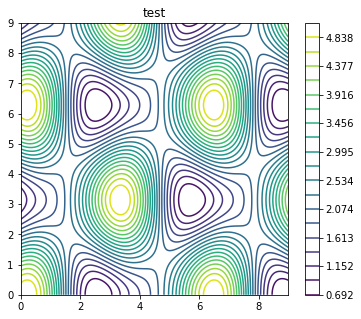

In [6]:
F = lambda x, y: 2.575 - 2*np.cos(x)*np.cos(y+np.pi) - 0.575*np.cos(1.25*np.pi - 2*x)
contour_plot(F, xlim=(0,9), ylim=(0,9), title='test')

### Task 3. Visualize both firms for a given parameterization

Let the parameters of the model be

$$
\alpha = 0.5,\quad \sigma=0.75
$$

Make the following plots to visualize the primitives of the model:
1. Inverse demand functions for the two firms
2. Profit functions of the two firms
4. Cost function of the two firms, making 2 lines in one figure

Use the started code below.

In [ ]:
# Write your code here

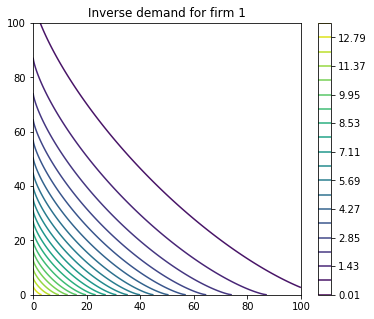

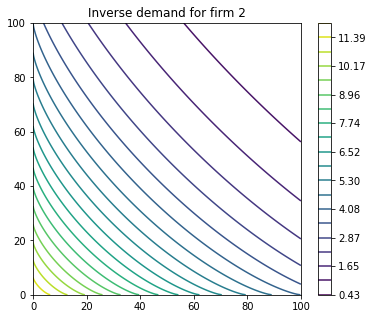

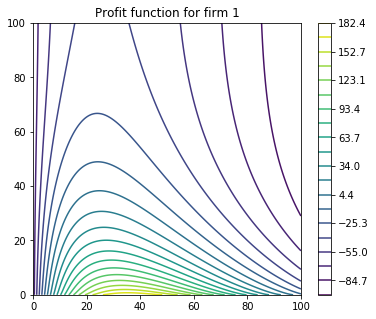

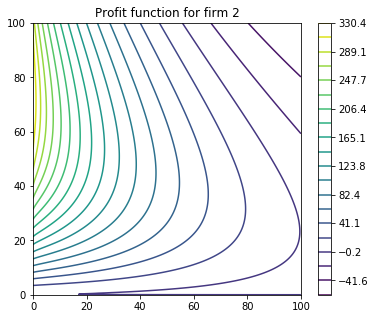

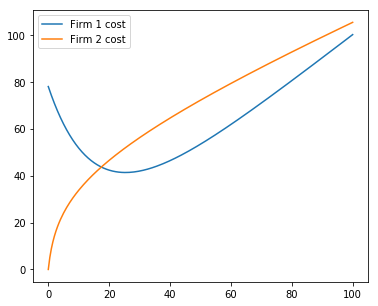

In [7]:
f1=firm(1,label='firm 1',alpha=0.5,sigma=0.75)
f2=firm(2,label='firm 2',alpha=0.5,sigma=0.75)

contour_plot(f1.demand,title='Inverse demand for firm 1')
contour_plot(f2.demand,title='Inverse demand for firm 2')
contour_plot(f1.profit,title='Profit function for firm 1')
contour_plot(f2.profit,title='Profit function for firm 2')

# costs plots
q = np.linspace(0,100,200)
fig, ax = plt.subplots(figsize=(6,5))
plt.plot(q,f1.cost(q),label='Firm 1 cost')
plt.plot(q,f2.cost(q),label='Firm 2 cost')
plt.legend()

### Task 4. Develop a class to represent best response function

The best response function of each firm is the optimal choice
of their own quantity as a function of the choice of quantity
by the other firm.
The crossing point or points of the best response function of two
firms corresponds to equilibria in the asymmetric Cournot model.

Use the code below to update the polyline class from weekly assignment 5
for the needs of this model.  The class should implement the piece-wise
linear line in a $ q_1 $-$ q_2 $ plane, extend the line by
adding a new point, and compute the intersections between two such
lines.  The  difference from the polyline class in the assignment
is that the points have to maintain the natural order rather than
being sorted.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class best_response_line():
    '''Class that implements the piecewise linear best responce functions'''

    def __repr__(self):
        '''Print for best response functions'''
        return self.__str__(self)

    def __str__(self):
        '''String representation for best response functions'''
        return 'Best response "%s" with q1=%s, q2=%s' % (self.label,self.q1,self.q2)

    def __init__(self,q1=[],q2=[],label=''):
        '''Constructor for best response function class'''
        # one dimensional np arrays
        q1 = np.array(q1).flatten()
        q2 = np.array(q2).flatten()
        # save arguments as object properties
        self.q1, self.q2 = q1, q2
        self.label = label

    def __len__(self):
        '''Returns the length of polyline'''
        return self.q1.size

    def add_point(self,q1,q2):
        '''Adds one more point to the best response'''
        self.q1 = np.append(self.q1,q1)
        self.q2 = np.append(self.q2,q2)

    def plot(self, **kvargs):
        '''Plot of the line'''
        plt.plot(self.q1,self.q2,label=self.label,**kvargs)
        return

    def intersect(self,other):
        '''Finds all intersection points of two best_response_lines'''
        intersections=[]
        if isinstance(other,best_response_line):
            for i in range(len(self)-1):
                for j in range(len(other)-1):
                    # check if segments i and j intersect
                    intr = self.__intersect_segments(self.q1[i],self.q2[i],
                                                     self.q1[i+1],self.q2[i+1],
                                                     other.q1[j],other.q2[j],
                                                     other.q1[j+1],other.q2[j+1])
                    if intr:
                        intersections.append(list(intr))
            return np.array(intersections)
        else:
            raise TypeError('Only polyline can be intersected')

    def __intersect_segments(self,*arg):
        '''Find intersection of two line segments given by 4 (x,y) points'''
        # unpack parameters
        x11,y11,x12,y12=arg[:4] #first line segment
        x21,y21,x22,y22=arg[4:] #second line segment
        # bounding box check: whether intersection is possible in principle
        bb = ( min(x11,x12)<max(x21,x22) and min(x21,x22)<max(x11,x12) and
               min(y11,y12)<max(y21,y22) and min(y21,y22)<max(y11,y12) )
        if not bb:
            return None
        # form system of equations
        A = np.array([[x12-x11,0,-1,0],[0,x22-x21,-1,0],[y12-y11,0,0,-1],[0,y22-y21,0,-1]])
        b = np.array([-x11,-x21,-y11,-y21])
        t1,t2,x0,y0 = np.linalg.solve(A,b)
        if 0 <= t1 <= 1 and 0 <= t2 <= 1:
            return x0,y0
        else:
            return None

Test your work using the code below, which should find and mark one intersection

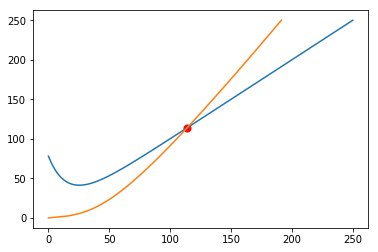

In [9]:
qm = np.linspace(0,250,100)
f1, f2 = firm(1), firm(2)
line1 = best_response_line(qm, f1.cost(qm))
line2 = best_response_line(f2.cost(qm), qm)
eqb = line1.intersect(line2)

line1.plot()
line2.plot()
plt.scatter(eqb[:,0],eqb[:,1],c='red',s=50)
plt.show()

### Task 5. Compute and plot best response function

Compute the best response of each firm under the same parameters as in Task 3.

This function should take the firm object as input and return a best_response_line
object. A grid over quantities $ q_{-1} $ which is interpreted as the choice of
**other** firm, should be an optional input which defaults to a reasonable default
grid.
The function should solve the profit maximization problem using Newton method (see week 6 assignment)
for **this** firm for every value of $ q_{-1} $, and build a **best_response_line**
representing this function.

Plot the best response curves over profit contour plot for each firm
to visually check if the returned values are indeed best responses.

Use the starter code below.

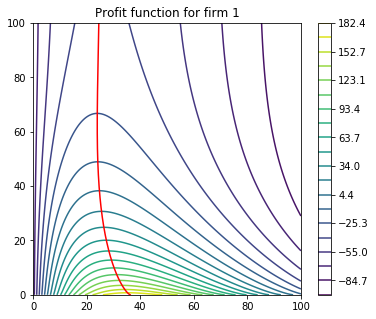

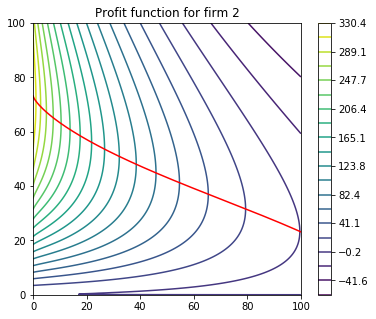

In [11]:
def newton(fun, grad, x0, tol=1e-12, maxiter=100, callback=None):
    '''Newton method to solve fun(x)=0
       Callback function arguments (iter,x,x1,err)
    '''
    x=x0
    for iter in range(maxiter):
        x1 = x - fun(x)/grad(x)
        err = np.abs(x1-x)
        if callback:
            callback(iter,x,x1,err)
        if err < tol:
            return x1
        x = x1
    else:
        raise(RuntimeError('Failed to converge, increase maxiter'))

def best_response(firm, qm=None):
    '''This function return a best_response_line object that represents the best
       response for the firm passed in the first argument to the quantities of
       the competitor passed in the second argument'''
    if not np.any(qm):
        #default grid for the other firm
        qm = np.linspace(1e-6,100,250)
    br = best_response_line(label="Best response of fimr %d to the firm's %d quantities"%(firm.index,3-firm.index))
    x0 = (qm[0]+qm[-1])/2 # initial starting value
    for q in qm:
        if firm.index==1:
            fun = lambda x: firm.dprofit(x, q)
            grad = lambda x: firm.d2profit(x, q)
            q1 = newton(fun,grad,x0,maxiter=1000)
            x0 = q1 # next starting value is previous optimum
            br.add_point(q1,q)
        else:
            fun = lambda x: firm.dprofit(q, x)
            grad = lambda x: firm.d2profit(q, x)
            q2 = newton(fun,grad,x0,maxiter=1000)
            x0 = q2 # next starting value is previous optimum
            br.add_point(q,q2)
    return br

alpha,sigma = 0.5,0.75
f1=firm(1,alpha,sigma,'firm 1')
f2=firm(2,alpha,sigma,'firm 2')
br1 = best_response(f1) #best response of firm 1
br2 = best_response(f2) #best response of firm 2

contour_plot(f1.profit,title='Profit function for firm 1')
br1.plot(color='red')
plt.show()

contour_plot(f2.profit,title='Profit function for firm 2')
br2.plot(color='red')
plt.show()

### Task 6. Compute and plot equilibria of the model

Compute and plot the best responses, and mark the equilibria for the
following pairs of model parameters:

$$
(\alpha,\sigma) \in \{(0.5,0.75),(0.125,1.95),(0.15,0.75)\}
$$

In [ ]:
# write your code here

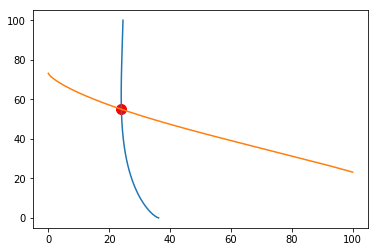

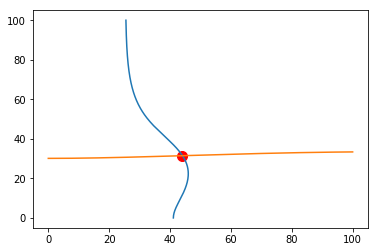

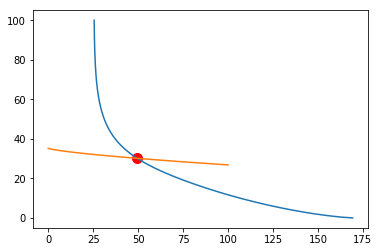

In [12]:
for alpha,sigma in [(0.5,0.75),(0.125,1.95),(0.15,0.75)]:

    f1=firm(1,alpha,sigma)
    f2=firm(2,alpha,sigma)
    br1 = best_response(f1)
    br2 = best_response(f2)
    eqb = br1.intersect(br2)

    br1.plot()
    br2.plot()
    plt.scatter(eqb[:,0],eqb[:,1],c='red',s=100)
    plt.show()

Give economically intuitive interpretation to the observed variation of
equilibria.